In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!ls '/content/gdrive/My Drive/'

bitirme_demo_final  Chatbot  Chatbot_old  Latent-semantic-indexing-master


In [3]:

%cd '/content/gdrive/My Drive/bitirme_demo_final/Chatbot'

/content/gdrive/My Drive/bitirme_demo_final/Chatbot


In [8]:
import re

cumleler = open('corpus/movie_lines.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

konusmalar = open('corpus/movie_conversations.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

exchn = []
for konusma in konusmalar:
    exchn.append(konusma.split(' +++$+++ ')[-1][1:-1].replace("'", " ").replace(",","").split())

diag = {}
for cumle in cumleler:
    diag[cumle.split(' +++$+++ ')[0]] = cumle.split(' +++$+++ ')[-1]

## delete
del(cumleler, konusmalar, konusma, cumle)

sorular = []
cevaplar = []

for konusma in exchn:
    for i in range(len(konusma) - 1):
        sorular.append(diag[konusma[i]])
        cevaplar.append(diag[konusma[i+1]])

## delete
del(diag, exchn, konusma, i)



sorted_soru = []
sorted_cevap = []
for i in range(len(sorular)):
    if (len(sorular[i]) < 30) and (len(cevaplar[i]) < 30):
        sorted_soru.append(sorular[i])
        sorted_cevap.append(cevaplar[i])

len(sorted_cevap)
def temizle_txt(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"it's", "it is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "that is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"how's", "how is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "cannot", txt)
    txt = re.sub(r"n't", " not", txt)
    txt = re.sub(r"n'", "ng", txt)
    txt = re.sub(r"'bout", "about", txt)
    txt = re.sub(r"'til", "until", txt)
    txt = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", txt)
    return txt

temizle_soru = []
temizle_cevap = []

for cumle in sorted_soru:
    temizle_soru.append(temizle_txt(cumle))
        
for cumle in sorted_cevap:
    temizle_cevap.append(temizle_txt(cumle))



del(cevaplar, sorular, cumle)



for i in range(len(temizle_cevap)):
    temizle_cevap[i] = ' '.join(temizle_cevap[i].split()[:11])




del(sorted_cevap, sorted_soru)
temizle_soru_=temizle_soru[:45000]
temizle_cevap=temizle_cevap[:45000]

word2count = {}

for cumle in temizle_soru:
    for word in cumle.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for cumle in temizle_cevap:
    for word in cumle.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1


del(word, cumle)


thresh = 5

vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1
    

del(word2count, word, count, thresh)       
del(word_num)        



for i in range(len(temizle_cevap)):
    temizle_cevap[i] = '<SOS> ' + temizle_cevap[i] + ' <EOS>'



tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1

for k,i in vocab.items():
    if i == 0:
        print(k)

vocab['there'] = vocab['<PAD>']
vocab['<PAD>'] = 0

## delete
del(token, tokens) 
del(x)


inv_vocab = {w:v for v, w in vocab.items()}


encoder_inp = []
for cumle in temizle_soru:
    lst = []
    for word in cumle.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for cumle in temizle_cevap:
    lst = []
    for word in cumle.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

### delete
del(temizle_cevap, temizle_soru, cumle, lst, word)



from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, 13, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 13, padding='post', truncating='post')




decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 

decoder_final_output = pad_sequences(decoder_final_output, 13, padding='post', truncating='post')


del(i)



VOCAB_SIZE = len(vocab)
MAX_LEN = 13

from tensorflow.keras.utils import to_categorical
decoder_final_output = to_categorical(decoder_final_output, len(vocab))


there


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
import numpy as np


enc_inp = Input(shape=(13, ))
dec_inp = Input(shape=(13, ))


VOCAB_SIZE = len(vocab)
embed = Embedding(VOCAB_SIZE+1, output_dim=50, 
                  input_length=13,
                  trainable=True                  
                  )


enc_embed = embed(enc_inp)
enc_lstm = LSTM(400 ,return_sequences=True, return_state=True,dropout=0.05)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c]



dec_embed = embed(dec_inp)
dec_lstm = LSTM(400,  return_sequences=True, return_state=True,dropout=0.05)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

dense = Dense(VOCAB_SIZE, activation='softmax')

dense_op = dense(dec_op)







In [10]:
model = Model([enc_inp, dec_inp], dense_op)


In [11]:
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

In [ ]:
history=model.fit([encoder_inp, decoder_inp],decoder_final_output,epochs=20)

Epoch 1/20
  62/1343 [>.............................] - ETA: 8:58 - loss: 0.8028 - acc: 0.8226

t=2022-06-03T11:12:11+0000 lvl=warn msg="failed to open private leg" id=9fc47cec401c typ=proxy privaddr=localhost:22 err="dial tcp 127.0.0.1:22: connect: connection refused"


 149/1343 [==>...........................] - ETA: 6:31 - loss: 0.8086 - acc: 0.8206

t=2022-06-03T11:12:34+0000 lvl=warn msg="failed to open private leg" id=77d510357682 typ=proxy privaddr=localhost:22 err="dial tcp 127.0.0.1:22: connect: connection refused"


1343/1343 [==============================] - 376s 280ms/step - loss: 0.8357 - acc: 0.8164
Epoch 2/20
 160/1343 [==>...........................] - ETA: 5:48 - loss: 0.7930 - acc: 0.8245

t=2022-06-03T11:18:48+0000 lvl=warn msg="failed to open private leg" id=86c652bd71d3 typ=proxy privaddr=localhost:22 err="dial tcp 127.0.0.1:22: connect: connection refused"


 237/1343 [====>.........................] - ETA: 5:22 - loss: 0.7965 - acc: 0.8239

t=2022-06-03T11:19:11+0000 lvl=warn msg="failed to open private leg" id=acd62b36f38d typ=proxy privaddr=localhost:22 err="dial tcp 127.0.0.1:22: connect: connection refused"


1343/1343 [==============================] - 409s 305ms/step - loss: 0.8199 - acc: 0.8194
Epoch 3/20
 447/1343 [========>.....................] - ETA: 4:56 - loss: 0.7911 - acc: 0.8245

t=2022-06-03T11:27:18+0000 lvl=warn msg="failed to open private leg" id=8e8ec33f361a typ=proxy privaddr=localhost:22 err="dial tcp 127.0.0.1:22: connect: connection refused"


 832/1343 [=================>............] - ETA: 2:46 - loss: 0.7990 - acc: 0.8232

In [ ]:
model.save('chatbot.h5')
model.save_weights('chatbot_weights_30.h5')

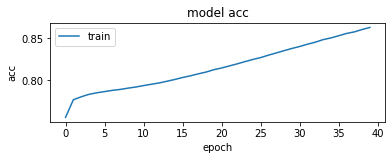

In [ ]:
from matplotlib import pyplot as plt

plt.figure(1)  
 
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')

  
plt.show()

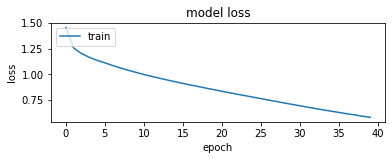

In [ ]:
from matplotlib import pyplot as plt

plt.figure(1)  
 

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


enc_model = Model([enc_inp], enc_states)



# decoder Model
decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = dec_lstm(dec_embed , initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
dec_model = Model([dec_inp, decoder_states_inputs],
                                      [decoder_outputs] + decoder_states)

In [ ]:
import numpy as np


from keras.preprocessing.sequence import pad_sequences
print("HELLO I AM OZİ")
from flask import Flask, request,render_template

from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)
prepro3 =""

@app.route("/")
def home(): 
    return render_template("index.html")

@app.route("/get")

def get_bot_response():
 ##def func():
  prepro1 = ""
  userInput = request.args.get('msg')
  userInput = prepro1

  while prepro1 != 'Bye':
   
    prepro1 = ""
    #prepro1 = input("you : ")
    prepro1 = temizle_txt(prepro1)
    prepro = [prepro1]
    
    txt = []
    for x in prepro:
        lst = []
        for y in x.split():
            try:
                lst.append(vocab[y])
            except:
                lst.append(vocab['<OUT>'])
        txt.append(lst)
        
    
    txt = pad_sequences(txt, 13, padding = 'post')
    
    stat = enc_model.predict(txt)
    
    empty_target_seq = np.zeros((1,1))
    
    empty_target_seq[0,0] = vocab['<SOS>']
    
    stop_condition = False
    decoded_translation = ''
    
    while not stop_condition:
        
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + stat )
        
        decoder_concat_input = dense(dec_outputs)
        
        sampled_word_index = np.argmax(decoder_concat_input[0,-1,:])
        
        sampled_word = inv_vocab[sampled_word_index] + " "
        
        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word
        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
            stop_condition = True

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        stat = [ h , c ]
       
       
    return str(decoded_translation)
if __name__ == "__main__":
  
  app.run()



    ##print("OZİ : ", decoded_translation ),









HELLO I AM OZİ
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://cf38-34-135-228-106.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [02/Jun/2022 14:32:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2022 14:32:39] "GET /pngwing.com.png HTTP/1.1" 404 -


127.0.0.1 - - [02/Jun/2022 14:32:46] "GET /get?msg=hello HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2022 14:32:55] "GET /get?msg=hi HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2022 14:32:57] "GET /get?msg=merhaba HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2022 14:33:01] "GET /get?msg=how%20are%20you HTTP/1.1" 200 -


In [4]:
!pip install flask_ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 5.4 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=3e51f0d9e41d00e159aec7430fe6856fbd761b48bd4a81d0de21fb55c773fc76
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [6]:
!ngrok authtoken 29GsAF68lPxmQSqCWw8Xvf9Wqiw_4iZ65un3AchPnCY7bfi71

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [7]:
import getpass

from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth%22")
conf.get_default().auth_token = getpass.getpass()

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect(22, "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with ssh root@{ssh_url} -p{port}")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth%22
··········
 * ngrok tunnel available, access with ssh root@4.tcp.ngrok.io -p10023
